<a href="https://colab.research.google.com/github/PisanoRaffaele/Lab_AI/blob/main/Copia_di_QuickDrawCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Preambolo**


##Librerie

In [113]:
 #!pip3 install wget
 #!pip install --quiet pytorch-lightning>=1.5

In [114]:
import wget
import os
import numpy
import matplotlib.pyplot as pyplot
import random
from types import SimpleNamespace
from pathlib import Path
import math

# PyTorch Lightning
import torch
import torch.nn as nn
import torch.utils.data as data
import torch.optim as optim
import pytorch_lightning as pl

# Torchvision
import torchvision
from torchvision import transforms
from torchvision import datasets

## Path e seed

I modelli gia addestrastri verranno salvati in questo path in modo da poterli riperndere se si sceglie di runnare con gli stessi samples e parametri.
Anche i dati .npy verranno salvati qui.

In [115]:
CHECKPOINT_PATH = "../saved_models/"
DATA_PATH = "../saved_models/"

os.makedirs(CHECKPOINT_PATH, exist_ok=True)
os.makedirs(DATA_PATH, exist_ok=True)

Impostare il seed significa stabilire un valore iniziale per il generatore di numeri casuali. Questo consente di ottenere risultati riproducibili durante l'esecuzione di codice che coinvolge operazioni casuali.

In [116]:
def set_seed(seed):
    random.seed(seed)
    numpy.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)

    pl.seed_everything(seed)

set_seed(42)

INFO:lightning_fabric.utilities.seed:Global seed set to 42


Se disponibilie, usiamo il GPU

In [117]:
# garantisce il determinismo delle operazioni eseguite sulla GPU (se disponibile) in modo da ottenere risultati riproducibili.
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")

print(device)

cuda:0


## Dataset Download

###Download .npy

Prendiamo tutte le categorie del dataset salvate in https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/
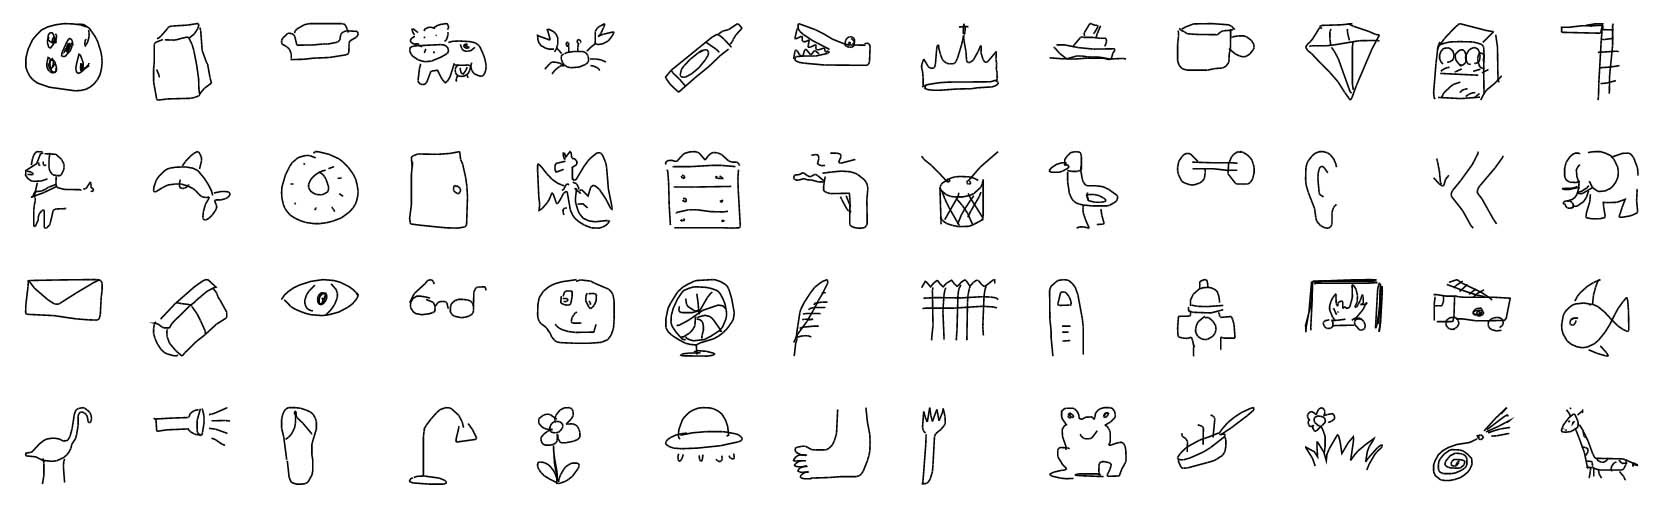

In [118]:
categories = [
     "aircraft carrier", "airplane", "alarm clock", "ambulance", "angel", "animal migration",
     "ant", "anvil", "apple", "arm", "asparagus", "axe", "backpack", "banana", "bandage", "barn",
     "baseball", "baseball bat", "basket", "basketball", "bat", "bathtub", "beach", "bear", "beard",
      "bed", "bee", "belt", "bench", "bicycle", "binoculars", "bird", "birthday cake", "blackberry",
      "blueberry", "book", "boomerang", "bottlecap", "bowtie", "bracelet", "brain", "bread", "bridge",
      "broccoli", "broom", "bucket", "bulldozer", "bus", "bush", "butterfly", "cactus", "cake",
      "calculator", "calendar", "camel", "camera", "camouflage", "campfire", "candle", "cannon",
      "canoe", "car", "carrot", "castle", "cat", "ceiling fan", "cello", "cell phone", "chair",
      "chandelier", "church", "circle", "clarinet", "clock", "cloud", "coffee cup", "compass",
      "computer", "cookie", "cooler", "couch", "cow", "crab", "crayon", "crocodile", "crown",
      "cruise ship", "cup", "diamond", "dishwasher", "diving board", "dog", "dolphin", "donut",
      "door", "dragon", "dresser", "drill", "drums", "duck", "dumbbell", "ear", "elbow", "elephant",
      "envelope", "eraser", "eye", "eyeglasses", "face", "fan", "feather", "fence", "finger",
      "fire hydrant", "fireplace", "firetruck", "fish", "flamingo", "flashlight", "flip flops",
      "floor lamp", "flower", "flying saucer", "foot", "fork", "frog", "frying pan", "garden",
      "garden hose", "giraffe", "goatee", "golf club", "grapes", "grass", "guitar", "hamburger",
      "hammer", "hand", "harp", "hat", "headphones", "hedgehog", "helicopter", "helmet", "hexagon",
      "hockey puck", "hockey stick", "horse", "hospital", "hot air balloon", "hot dog", "hot tub",
      "hourglass", "house", "house plant", "hurricane", "ice cream", "jacket", "jail", "kangaroo",
      "key", "keyboard", "knee", "knife", "ladder", "lantern", "laptop", "leaf", "leg", "light bulb",
      "lighter", "lighthouse", "lightning", "line", "lion", "lipstick", "lobster", "lollipop",
      "mailbox", "map", "marker", "matches", "megaphone", "mermaid", "microphone", "microwave",
      "monkey", "moon", "mosquito", "motorbike", "mountain", "mouse", "moustache", "mouth", "mug",
      "mushroom", "nail", "necklace", "nose", "ocean", "octagon", "octopus", "onion", "oven", "owl",
      "paintbrush", "paint can", "palm tree", "panda", "pants", "paper clip", "parachute", "parrot",
      "passport", "peanut", "pear", "peas", "pencil", "penguin", "piano", "pickup truck",
      "picture frame", "pig", "pillow", "pineapple", "pizza", "pliers", "police car", "pond", "pool",
      "popsicle", "postcard", "potato", "power outlet", "purse", "rabbit", "raccoon", "radio", "rain",
      "rainbow", "rake", "remote control", "rhinoceros", "rifle", "river", "roller coaster",
      "rollerskates", "sailboat", "sandwich", "saw", "saxophone", "school bus", "scissors", "scorpion",
      "screwdriver", "sea turtle", "see saw", "shark", "sheep", "shoe", "shorts", "shovel", "sink",
      "skateboard", "skull", "skyscraper", "sleeping bag", "smiley face", "snail", "snake", "snorkel",
      "snowflake", "snowman", "soccer ball", "sock", "speedboat", "spider", "spoon", "spreadsheet",
      "square", "squiggle", "squirrel", "stairs", "star", "steak", "stereo", "stethoscope", "stitches",
      "stop sign", "stove", "strawberry", "streetlight", "string bean", "submarine", "suitcase", "sun",
      "swan", "sweater", "swing set", "sword", "syringe", "table", "teapot", "teddy-bear", "telephone",
      "television", "tennis racquet", "tent", "The Eiffel Tower", "The Great Wall of China", "The Mona Lisa",
      "tiger", "toaster", "toe", "toilet", "tooth", "toothbrush", "toothpaste", "tornado", "tractor",
      "traffic light", "train", "tree", "triangle", "trombone", "truck", "trumpet", "t-shirt", "umbrella",
      "underwear", "van", "vase", "violin", "washing machine", "watermelon", "waterslide", "whale", "wheel",
      "windmill", "wine bottle", "wine glass", "wristwatch", "yoga", "zebra", "zigzag"
]

In [119]:
dataset_url = "https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/"

i = 1
for category in categories:
  if not os.path.exists("../saved_models/" + str(category) + ".npy"):
    category_url = dataset_url + str(category) + ".npy"
    wget.download(url = category_url, out = "../saved_models/")
    print(str(category) + " DWLD", end = " | ")
  else:
    print(str(category) + " OK", end = " | ")
  if (i % 16 == 0):
    print("")
  i += 1

aircraft carrier OK | airplane OK | alarm clock OK | ambulance OK | angel OK | animal migration OK | ant OK | anvil OK | apple OK | arm OK | asparagus OK | axe OK | backpack OK | banana OK | bandage OK | barn OK | 
baseball OK | baseball bat OK | basket OK | basketball OK | bat OK | bathtub OK | beach OK | bear OK | beard OK | bed OK | bee OK | belt OK | bench OK | bicycle OK | binoculars OK | bird OK | 
birthday cake OK | blackberry OK | blueberry OK | book OK | boomerang OK | bottlecap OK | bowtie OK | bracelet OK | brain OK | bread OK | bridge OK | broccoli OK | broom OK | bucket OK | bulldozer OK | bus OK | 
bush OK | butterfly OK | cactus OK | cake OK | calculator OK | calendar OK | camel OK | camera OK | camouflage OK | campfire OK | candle OK | cannon OK | canoe OK | car OK | carrot OK | castle OK | 
cat OK | ceiling fan OK | cello OK | cell phone OK | chair OK | chandelier OK | church OK | circle OK | clarinet OK | clock OK | cloud OK | coffee cup OK | compass OK | computer OK 

## Parametri principali addestramento

Alcuni parametri principaeli dell' addestramento:

In [120]:
batchSize = 128

trainingSamples = 360
testSamples = int(trainingSamples / 4)
valSamples = int(trainingSamples / 4)

epochs = 120

optimizerName = "SGD" # {Adam, SGD}
modelName = "ResNet" # {GoogleNet, ResNet}

actFnName = "relu" # { "tanh", "relu", "leakyrelu", "gelu"}

#optimizerHparams
learningRate = 0.1 # di solito: {1e-3, 0.1}
weightDeacy = 1e-4 # di solito: {1e-4}


numCategories = len(categories)
TotSamples = (trainingSamples + testSamples + valSamples) * numCategories

foundPreTrained = False;

tp_count = [0] * numCategories
tn_count = [0] * numCategories
fn_count = [0] * numCategories
fp_count = [0] * numCategories

def print_params():
  print("Categories: " + str(numCategories))
  print("TotSamples: " + str(TotSamples))
  print("batchSize: " + str(batchSize))
  print("optimizerName: " + optimizerName)
  print("modelName: " + modelName)
  print("actFnName: " + actFnName)
  print("learningRate: " + str(learningRate))
  print("weightDeacy: " + str(weightDeacy))

## Dataset

###Heatmap

Per visualizzare una Heatmap delle varie classi fatta tramite una media

In [121]:
heatmapDictonary = {}

def get_label_heatmap(value):

    heatmap = numpy.mean(value, axis=0) # media

    return heatmap

In [122]:
def visualize_heatmaps():

  figure, axes = pyplot.subplots(35, 10, figsize=(15, 30))
  x = 0
  for key, value in heatmapDictonary.items():

    value = value[:784]
    value = value.reshape(1, 28, 28).astype("float32")
    value = (value - 127.5) / 127.5

    i = x // 10
    j = x % 10
    x += 1

    axes[i,j].set_title(key)
    axes[i,j].imshow(value.reshape(28, 28).squeeze())
    axes[i,j].axis('off')

  pyplot.subplots_adjust(hspace=0.9)
  pyplot.show()


###DataArray

Costruiamo a partire dai file .npy tre array di samples con dentro un numero uguale per ogni classe.
Ogni array servirà per uno scopo diverso:
- il trainDataset serve per addestrare il modello, cioè per insegnare al modello a riconoscere i modelli e le caratteristiche nelle immagini di input
- il testDataset è utilizzato per valutare le prestazioni del modello su dati non visti durante l'addestramento
- il valDataset è per regolare i parametri del modello e selezionare l'architettura migliore attraverso l'ottimizzazione dei parametri

In [ ]:
i = 0;
for category in categories:
  samples = numpy.load(DATA_PATH + str(category) + ".npy", allow_pickle=True)
  campione = random.randint(0, 90000)
  samplesMin = samples[campione : campione + TotSamples]

  del samples

  value = samplesMin.astype("float32")

  del samplesMin

  if (i == 0):
    valueArray = numpy.c_[value, numpy.zeros(len(value))]
  else:
    valueArray = numpy.c_[value, i * numpy.ones(len(value))]

  del value

  numpy.random.shuffle(valueArray)

  heatmapDictonary[str(category)] = get_label_heatmap(valueArray)

  if (i == 0):
    numpytrainData = valueArray[:trainingSamples]
    numpytestData = valueArray[trainingSamples : trainingSamples + testSamples]
    numpyvalData = valueArray[trainingSamples + testSamples : trainingSamples + testSamples + valSamples]
  else:
    numpytrainData = numpy.concatenate((numpytrainData, valueArray[:trainingSamples]))
    numpytestData = numpy.concatenate((numpytestData, valueArray[trainingSamples : trainingSamples + testSamples]))
    numpyvalData = numpy.concatenate((numpyvalData, valueArray[trainingSamples + testSamples : trainingSamples + testSamples + valSamples]))
  i = i + 1
  del valueArray

In [ ]:
#visualize_heatmaps()

###Visualize

per visualizzare qualche sample

In [ ]:
def visualTrainingSet(x, y):
	figure, axes = pyplot.subplots(5, 10, figsize=(20, 10))

	for label in range(0, 50):

		randomLabel = numpy.random.randint(0, len(x) - 1)

		image = x[randomLabel].reshape((28, 28))
		title = categories[y[randomLabel]]

		xCordinate = label // 10

		yCordinate = label % 10

		axes[xCordinate, yCordinate].set_title(title)
		axes[xCordinate, yCordinate].imshow(image)
		axes[xCordinate, yCordinate].axis('off')

	pyplot.show()

###Training set

Passaggio dei dati e dei labels in tensori

In [ ]:
trainX = numpytrainData[:, :784] # vengono estratte le prime 784 celle (28x28) (corrispondenti ai pixel delle immagini) e assegnate a trainX

trainY = numpytrainData[:, -1].astype("int") # viene estratta l'ultima colonna (corrispondente alle etichette delle immagini) e assegnata a trainY.

del numpytrainData

trainX = trainX.reshape(trainX.shape[0], 1, 28, 28).astype("float32")  #reshape in im 28x28

trainX = (trainX - 127.5) / 127.5 #normalization it (to [0,1])

#visualTrainingSet(trainX, trainY)

In [ ]:
trainX_tensor = torch.from_numpy(trainX).float()
trainY_tensor = torch.from_numpy(trainY).long()

del trainX
del trainY

###Test set

In [ ]:
testX = numpytestData[:, :784]
testY = numpytestData[:, -1].astype("int")

del numpytestData

testX = testX.reshape(testX.shape[0], 1, 28, 28).astype("float32")
testX = (testX - 127.5) / 127.5

#visualTrainingSet(testX, testY)

In [ ]:
testX_tensor = torch.from_numpy(testX).float()
testY_tensor = torch.from_numpy(testY).long()

del testX
del testY

###Validation set

In [ ]:
valX = numpyvalData[:, :784]
valY = numpyvalData[:, -1].astype("int")

del numpyvalData

valX = valX.reshape(valX.shape[0],1, 28, 28).astype("float32")
valX = (valX - 127.5) / 127.5

#visualTrainingSet(valX, valY)

In [ ]:
valX_tensor = torch.from_numpy(valX).float()
valY_tensor = torch.from_numpy(valY).long()

del valX
del valY

###SetsCreation

creazione dei set effettivi

In [ ]:
class CustomDataset(data.Dataset):
    def __init__(self, input_tensors, output_tensors):
        self.input_tensors = input_tensors
        self.output_tensors = output_tensors

    def __len__(self):
        return len(self.input_tensors)

    def __getitem__(self, index):
        input_tensor = self.input_tensors[index]
        output_tensor = self.output_tensors[index]
        # Applica eventuali trasformazioni o manipolazioni all'input e all'output
        modified_input = input_tensor
        modified_output = output_tensor
        return modified_input, modified_output

In [ ]:
train_set = CustomDataset(trainX_tensor, trainY_tensor)
test_set = CustomDataset(testX_tensor, testY_tensor)
val_set = CustomDataset(valX_tensor, valY_tensor)

del trainX_tensor
del trainY_tensor
del testX_tensor
del testY_tensor
del valX_tensor
del valY_tensor

Creazione dei loader

In [ ]:
train_loader = data.DataLoader(train_set, batch_size=batchSize, shuffle=True, drop_last=True, pin_memory=True, num_workers=2)
val_loader = data.DataLoader(val_set, batch_size=batchSize, shuffle=False, drop_last=False, num_workers=2)
test_loader = data.DataLoader(test_set, batch_size=batchSize, shuffle=False, drop_last=False, num_workers=2)

#**Modello**

##Classe

- *model_name:* usato per sfruttare eventualmente differenti modelli di CNN
- *model_hparams:* Iperparametri per il modello
- *optimizer_name:* Il nome dell'ottimizzatore da utilizzare. Attualmente supportati: Adam, SGD.
- *optimizer_hparams:* Iperparametri per l'ottimizzatore (learning rate, weight deacy, ...)

**Ottimizzatori**
> Gli ottimizzatori sono algoritmi utilizzati nell'addestramento delle reti neurali per aggiornare i pesi dei modelli al fine di minimizzare la funzione di perdita durante la fase di apprendimento. L'obiettivo dell'ottimizzazione è trovare i valori ottimali dei pesi del modello. Gli ottimizzatori eseguono il compito di regolare i pesi dei nodi in base al gradiente della funzione di perdita rispetto ai pesi.

>> **SGD**: L'idea di base dell'SGD è aggiornare iterativamente i pesi del modello utilizzando il gradiente calcolato su un batch casuale di dati di addestramento. L'algoritmo procede in cicli di selezione del batch, calcolo del gradiente e aggiornamento dei pesi. Questo processo continua fino a quando non viene raggiunta una condizione di convergenza.

>> **ADAM**: Combina le caratteristiche dell'algoritmo SGD con momenti e un tasso di apprendimento adattivo. Calcola e aggiorna i momenti di primo e secondo ordine dei pesi del modello, utilizzando i gradienti calcolati durante l'addestramento. Questo permette di adattare il tasso di apprendimento per ogni parametro in modo automatico, accelerando la convergenza e gestendo diverse scale dei gradienti.



In [ ]:
import torchmetrics
from sklearn.metrics import precision_score, recall_score, f1_score

class QuickDrawModule(pl.LightningModule):

    def __init__(self, model_name, model_hparams, optimizer_name, optimizer_hparams):

        super().__init__()

        self.save_hyperparameters()

        self.model = create_model(model_name, model_hparams)

        self.loss_module = nn.CrossEntropyLoss()

        self.example_input_array = torch.zeros((1, 1, 28, 28), dtype=torch.float32)

    def forward(self, imgs):
        return self.model(imgs)

    def configure_optimizers(self):
        # We will support Adam or SGD as optimizers.
        if self.hparams.optimizer_name == "Adam":
            # AdamW is Adam with a correct implementation of weight decay (see here for details: https://arxiv.org/pdf/1711.05101.pdf)
            optimizer = optim.AdamW(self.parameters(), **self.hparams.optimizer_hparams)
        elif self.hparams.optimizer_name == "SGD":
            optimizer = optim.SGD(self.parameters(), **self.hparams.optimizer_hparams)
        else:
            assert False, f"Unknown optimizer: \"{self.hparams.optimizer_name}\""


        # We will reduce the learning rate by 0.1 after 100 and 150 epochs
        scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[100, 150], gamma=0.1)
        return [optimizer], [scheduler]


    def training_step(self, batch, batch_idx):
        imgs, labels = batch
        preds = self.model(imgs)
        loss = self.loss_module(preds, labels)
        acc = (preds.argmax(dim=-1) == labels).float().mean()
        self.log('train_acc', acc, on_step=False, on_epoch=True)
        self.log('train_loss', loss)

        return loss

    def validation_step(self, batch, batch_idx):
        imgs, labels = batch
        preds = self.model(imgs).argmax(dim=-1)
        acc = (labels == preds).float().mean()
        self.log('val_acc', acc)

    def test_step(self, batch, batch_idx):
        imgs, labels = batch
        preds = self.model(imgs).argmax(dim=-1)

        for class_idx in range(numCategories):
          not_class_mask2 = preds != class_idx
          not_class_labels2 = labels[not_class_mask2]

          not_class_mask = preds == class_idx
          not_class_preds = preds[not_class_mask]
          not_class_labels = labels[not_class_mask]

          class_mask = labels == class_idx
          class_preds = preds[class_mask]
          class_labels = labels[class_mask]

          tp_count[class_idx] += (class_labels == class_preds).sum().item()
          fn_count[class_idx] += (class_labels != class_preds).sum().item()
          fp_count[class_idx] += (not_class_labels != not_class_preds).sum().item()
          tn_count[class_idx] += (not_class_labels2 != class_idx).sum().item()

        acc = (labels == preds).float().mean()
        self.log('test_acc', acc, on_step=False, on_epoch=True)


##Metodi

La callback LearningRateMonitor aggiunge il tasso di apprendimento corrente a TensorBoard, il che aiuta a verificare che il nostro scheduler del tasso di apprendimento funzioni correttamente. La callback ModelCheckpoint consente di personalizzare la procedura di salvataggio dei checkpoint. Ad esempio, è possibile specificare quanti checkpoint mantenere, quando salvare, quale metrica considerare, ecc.

In [ ]:
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint
from pytorch_lightning import Trainer

Per eventualmente runnare differenti modelli:

In [ ]:
model_dict = {}

def create_model(model_name, model_hparams):
    if model_name in model_dict:
        return model_dict[model_name](**model_hparams)
    else:
        assert False, f"Unknown model name \"{model_name}\". Available models are: {str(model_dict.keys())}"

Dizionario di funzioni per il modello

In [ ]:
fn_by_name = { "tanh": nn.Tanh, "relu": nn.ReLU, "leakyrelu": nn.LeakyReLU, "gelu": nn.GELU }

##Training

In [ ]:
import shutil

def train_model(model_name, save_name=None, **kwargs):

    if save_name is None:
        save_name = model_name

    trainer = pl.Trainer(default_root_dir=os.path.join(CHECKPOINT_PATH, save_name),                          # Specifica la directory in cui salvare i modelli
                         accelerator="gpu" if str(device).startswith("cuda") else "cpu",                     # Specifica se utilizzare una GPU o utilizzare solo la CPU
                         devices=1,                                                                          # Specifica il numero di GPU o CPU da utilizzare per l'addestramento
                         max_epochs=epochs,                                                                     # Specifica il numero massimo di epoche per l'addestramento
                         callbacks=[ModelCheckpoint(save_weights_only=True, mode="max", monitor="val_acc"),  # Specifica le callback da utilizzare durante l'addestramento...
                                    LearningRateMonitor("epoch")],                                             # Viene usata ModelCheckpoint: salva il miglior checkpoint in base alla val_acc massima
                         enable_progress_bar=True)                                                             # e LearningRateMonitor per registrare il tasso di apprendimento ad ogni epoca.
    trainer.logger._log_graph = True                                                                         # viene generato il grafico di computazione nel tensorboard.
    trainer.logger._default_hp_metric = True


    # Check whether pretrained model exists. If yes, load it and skip training
    versionfolderList = Path(os.path.join(CHECKPOINT_PATH, save_name, "lightning_logs/")).rglob("version_*")

    foundPreTrained = False

    for versionfolder in versionfolderList:
        CHECKPOINT_PATH_FILE = os.path.join(f"{versionfolder}/checkpoints/")
        checkpoint_files = list(Path(CHECKPOINT_PATH_FILE).rglob("finished.txt"))
        if (len(checkpoint_files) != 0):
            foundPreTrained = True;
            break;
        else:
            print(f"\nRemoving {versionfolder}... (old model not valid: incomplete training)\n")
            shutil.rmtree(versionfolder)

    if (foundPreTrained):
        pretrained_filename = list(Path(CHECKPOINT_PATH_FILE).rglob("*.ckpt"))[0]
    else:
        pretrained_filename = ""
        print("There is pretrained model: " + str(os.path.isfile(pretrained_filename)))

    if os.path.isfile(pretrained_filename):
        print(f"Found pretrained model at {pretrained_filename}, loading...")
        model = QuickDrawModule.load_from_checkpoint(pretrained_filename) # Automatically loads the model with the saved hyperparameters
    else:
        model = QuickDrawModule(model_name=model_name, **kwargs)
        train_results = trainer.fit(model, train_loader, val_loader)
        model = QuickDrawModule.load_from_checkpoint(trainer.checkpoint_callback.best_model_path) # Load best checkpoint after training

    test_result = trainer.test(model, test_loader, verbose=False)
    result = {"test_acc": test_result[0]["test_acc"]}#, "test_precision":test_result[0]["test_precision"], "test_recall":test_result[0]["test_recall"]}

    logs = trainer.logged_metrics
    return model, result, logs



## **GoogleNet**

###Inception Module


inception_block.svg

In [ ]:
class InceptionBlock(nn.Module):

    def __init__(self, c_in, c_red : dict, c_out : dict, act_fn):
        """
        Inputs:
            c_in - Number of input feature maps from the previous layers
            c_red - Dictionary with keys "3x3" and "5x5" specifying the output of the dimensionality reducing 1x1 convolutions
            c_out - Dictionary with keys "1x1", "3x3", "5x5", and "max"
            act_fn - Activation class constructor (e.g. nn.ReLU)
        """
        super().__init__()

        # 1x1 convolution branch
        self.conv_1x1 = nn.Sequential(
            nn.Conv2d(c_in, c_out["1x1"], kernel_size=1),
            nn.BatchNorm2d(c_out["1x1"]),
            act_fn()
        )

        # 3x3 convolution branch
        self.conv_3x3 = nn.Sequential(
            nn.Conv2d(c_in, c_red["3x3"], kernel_size=1),
            nn.BatchNorm2d(c_red["3x3"]),
            act_fn(),
            nn.Conv2d(c_red["3x3"], c_out["3x3"], kernel_size=3, padding=1),
            nn.BatchNorm2d(c_out["3x3"]),
            act_fn()
        )

        # 5x5 convolution branch
        self.conv_5x5 = nn.Sequential(
            nn.Conv2d(c_in, c_red["5x5"], kernel_size=1),
            nn.BatchNorm2d(c_red["5x5"]),
            act_fn(),
            nn.Conv2d(c_red["5x5"], c_out["5x5"], kernel_size=5, padding=2),
            nn.BatchNorm2d(c_out["5x5"]),
            act_fn()
        )

        # Max-pool branch
        self.max_pool = nn.Sequential(
            nn.MaxPool2d(kernel_size=3, padding=1, stride=1),
            nn.Conv2d(c_in, c_out["max"], kernel_size=1),
            nn.BatchNorm2d(c_out["max"]),
            act_fn()
        )

    def forward(self, x):
        x_1x1 = self.conv_1x1(x)
        x_3x3 = self.conv_3x3(x)
        x_5x5 = self.conv_5x5(x)
        x_max = self.max_pool(x)
        x_out = torch.cat([x_1x1, x_3x3, x_5x5, x_max], dim=1)
        return x_out

In [ ]:
class GoogleNet(nn.Module):

    def __init__(self, num_classes=numCategories, act_fn_name=actFnName, **kwargs):
        super().__init__()
        self.hparams = SimpleNamespace(num_classes=num_classes,
                                       act_fn_name=act_fn_name,
                                       act_fn=fn_by_name[act_fn_name])
        self._create_network()
        self._init_params()

    def _create_network(self):
        # A first convolution on the original image to scale up the channel size
        self.input_net = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            self.hparams.act_fn()
        )
        # Stacking inception blocks
        self.inception_blocks = nn.Sequential(
            InceptionBlock(64, c_red={"3x3": 32, "5x5": 16}, c_out={"1x1": 16, "3x3": 32, "5x5": 8, "max": 8}, act_fn=self.hparams.act_fn),
            InceptionBlock(64, c_red={"3x3": 32, "5x5": 16}, c_out={"1x1": 24, "3x3": 48, "5x5": 12, "max": 12}, act_fn=self.hparams.act_fn),
            nn.MaxPool2d(3, stride=2, padding=1),  # 32x32 => 16x16
            InceptionBlock(96, c_red={"3x3": 32, "5x5": 16}, c_out={"1x1": 24, "3x3": 48, "5x5": 12, "max": 12}, act_fn=self.hparams.act_fn),
            InceptionBlock(96, c_red={"3x3": 32, "5x5": 16}, c_out={"1x1": 16, "3x3": 48, "5x5": 16, "max": 16}, act_fn=self.hparams.act_fn),
            InceptionBlock(96, c_red={"3x3": 32, "5x5": 16}, c_out={"1x1": 16, "3x3": 48, "5x5": 16, "max": 16}, act_fn=self.hparams.act_fn),
            InceptionBlock(96, c_red={"3x3": 32, "5x5": 16}, c_out={"1x1": 32, "3x3": 48, "5x5": 24, "max": 24}, act_fn=self.hparams.act_fn),
            nn.MaxPool2d(3, stride=2, padding=1),  # 16x16 => 8x8
            InceptionBlock(128, c_red={"3x3": 48, "5x5": 16}, c_out={"1x1": 32, "3x3": 64, "5x5": 16, "max": 16}, act_fn=self.hparams.act_fn),
            InceptionBlock(128, c_red={"3x3": 48, "5x5": 16}, c_out={"1x1": 32, "3x3": 64, "5x5": 16, "max": 16}, act_fn=self.hparams.act_fn)
        )
        # Mapping to classification output
        self.output_net = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Linear(128, self.hparams.num_classes)
        )

    def _init_params(self):
        # Based on our discussion in Tutorial 4, we should initialize the convolutions according to the activation function
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(
                    m.weight, nonlinearity=self.hparams.act_fn_name)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        x = self.input_net(x)
        x = self.inception_blocks(x)
        x = self.output_net(x)
        return x

model_dict["GoogleNet"] = GoogleNet

##**ResNet**

L'idea delle connessioni residue è altamente efficace in quanto supporta una propagazione stabile del gradiente attraverso la rete. Invece di modellare direttamente una funzione H(x), modelliamo una funzione residuale F(x) = H(x) - x, dove H(x) rappresenta una mappatura non lineare. Applicando la retropropagazione su tali connessioni residue, otteniamo:

gradiente di H(x) = gradiente di F(x) + gradiente di x

L'aggiunta di F(x) al segnale di input x crea un percorso di connessione residuale che permette al gradiente di propagarsi più facilmente all'indietro attraverso la rete. Il fatto che il blocco ResNet abbia un bias verso la matrice identità (cioè F(x) = 0) garantisce una propagazione stabile del gradiente, riducendo l'effetto di F(x) stesso.

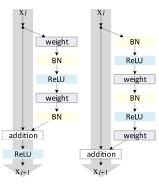

Il blocco ResNet originale applica una funzione di attivazione non lineare, di solito ReLU, dopo la connessione residuale.

Iniziamo con il blocco ResNet originale. La visualizzazione sopra mostra già quali strati sono inclusi in F(x). Un caso speciale che dobbiamo gestire è quando vogliamo ridurre le dimensioni dell'immagine in termini di larghezza e altezza. Il blocco ResNet base richiede che F(x) abbia la stessa forma di x. Pertanto, dobbiamo anche cambiare la dimensionalità di x prima di aggiungerlo a F(x). L'implementazione originale utilizzava un'identità con passo 2 e aggiungeva dimensioni aggiuntive con zeri. Tuttavia, l'implementazione più comune è utilizzare una convoluzione 1x1 con passo 2 poiché ci consente di cambiare la dimensionalità delle caratteristiche mantenendo un costo efficiente in termini di parametri e computazione. Il codice per il blocco ResNet è relativamente semplice, ed è mostrato di seguito.

In [ ]:
class ResNetBlock(nn.Module):

    def __init__(self, c_in, act_fn, subsample=False, c_out=-1):
        """
        Inputs:
            c_in - Number of input features
            act_fn - Activation class constructor (e.g. nn.ReLU)
            subsample - If True, we want to apply a stride inside the block and reduce the output shape by 2 in height and width
            c_out - Number of output features. Note that this is only relevant if subsample is True, as otherwise, c_out = c_in
        """
        super().__init__()
        if not subsample:
            c_out = c_in

        # Network representing F
        self.net = nn.Sequential(
            nn.Conv2d(c_in, c_out, kernel_size=3, padding=1, stride=1 if not subsample else 2, bias=False),  # No bias needed as the Batch Norm handles it
            nn.BatchNorm2d(c_out),
            act_fn(),
            nn.Conv2d(c_out, c_out, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(c_out)
        )

        # 1x1 convolution with stride 2 means we take the upper left value, and transform it to new output size
        self.downsample = nn.Conv2d(c_in, c_out, kernel_size=1, stride=2) if subsample else None
        self.act_fn = act_fn()

    def forward(self, x):
        z = self.net(x)
        if self.downsample is not None:
            x = self.downsample(x)
        out = z + x
        out = self.act_fn(out)
        return out

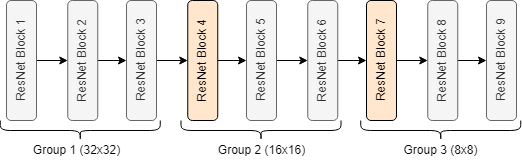

In [ ]:
resnet_blocks_by_name = {
    "ResNetBlock": ResNetBlock
}

In [ ]:
class ResNet(nn.Module):

    def __init__(self, num_classes=numCategories, num_blocks=[3,3,3], c_hidden=[16,32,64], act_fn_name="relu", block_name="ResNetBlock", **kwargs):
        """
        Inputs:
            num_classes - Number of classification outputs
            num_blocks - List with the number of ResNet blocks to use. The first block of each group uses downsampling, except the first.
            c_hidden - List with the hidden dimensionalities in the different blocks. Usually multiplied by 2 the deeper we go.
            act_fn_name - Name of the activation function to use, looked up in "act_fn_by_name"
            block_name - Name of the ResNet block, looked up in "resnet_blocks_by_name"
        """
        super().__init__()
        assert block_name in resnet_blocks_by_name
        self.hparams = SimpleNamespace(num_classes=num_classes,
                                       c_hidden=c_hidden,
                                       num_blocks=num_blocks,
                                       act_fn_name=act_fn_name,
                                       act_fn=fn_by_name[act_fn_name],
                                       block_class=resnet_blocks_by_name[block_name])
        self._create_network()
        self._init_params()

    def _create_network(self):
        c_hidden = self.hparams.c_hidden

        # A first convolution on the original image to scale up the channel size

        self.input_net = nn.Sequential(
            nn.Conv2d(1, c_hidden[0], kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(c_hidden[0]),
            self.hparams.act_fn()
        )

        # Creating the ResNet blocks
        blocks = []
        for block_idx, block_count in enumerate(self.hparams.num_blocks):
            for bc in range(block_count):
                subsample = (bc == 0 and block_idx > 0) # Subsample the first block of each group, except the very first one.
                blocks.append(
                    self.hparams.block_class(c_in=c_hidden[block_idx if not subsample else (block_idx-1)],
                                             act_fn=self.hparams.act_fn,
                                             subsample=subsample,
                                             c_out=c_hidden[block_idx])
                )
        self.blocks = nn.Sequential(*blocks)

        # Mapping to classification output
        self.output_net = nn.Sequential(
            nn.AdaptiveAvgPool2d((1,1)),
            nn.Flatten(),
            nn.Linear(c_hidden[-1], self.hparams.num_classes)
        )

    def _init_params(self):
        # Based on our discussion in Tutorial 4, we should initialize the convolutions according to the activation function
        # Fan-out focuses on the gradient distribution, and is commonly used in ResNets
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity=self.hparams.act_fn_name)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        x = self.input_net(x)
        x = self.blocks(x)
        x = self.output_net(x)
        return x

    # def set_thresholds(self, thresholds):
    #     assert len(thresholds) == self.hparams.num_classes
    #     self.thresholds = thresholds

    # def threshold_pred(self):
    #     x = self.input_net(x)
    #     x = self.blocks(x)
    #     x = self.output_net(x)
    #     binary_predictions = torch.zeros_like(x)
    #     for i, threshold in enumerate(self.thresholds):
    #         binary_predictions[:, i] = (x[:, i] > threshold).float()

    #     return binary_predictions

In [ ]:
model_dict["ResNet"] = ResNet

##**Training**

In [ ]:
NomeModello=f"{modelName}_{numCategories}classes_{TotSamples}samples"

optimizerHparams = {"lr": learningRate, "weight_decay": weightDeacy}

if modelName == "ResNet":
  optimizerHparams = {"lr": learningRate, "momentum": 0.9, "weight_decay": weightDeacy}



trained_model, results, logs = train_model(model_name = modelName,
                                                 save_name = NomeModello,
                                                 model_hparams={"num_classes": numCategories,
                                                                "act_fn_name": actFnName},
                                                 optimizer_name = optimizerName,
                                                 optimizer_hparams = optimizerHparams)


In [ ]:
directory = os.path.join(CHECKPOINT_PATH, NomeModello, "lightning_logs/version_0/checkpoints")

percorso_file = os.path.join(directory, "finished.txt")


with open(percorso_file, "w+") as file:
  if (not foundPreTrained):
    file.write(".")

##**Results**

In [ ]:
dir_tensorboard = os.path.join(CHECKPOINT_PATH, NomeModello, "lightning_logs/version_0")

# Load tensorboard extension
%load_ext tensorboard

# Opens tensorboard in notebook.
%tensorboard --logdir $dir_tensorboard --port=8008

In [ ]:
print_params()

In [ ]:
print(f"{modelName} Results", results)

In [ ]:
print('Accuracy:')
for i, category in enumerate(categories):
  print(str(category) + ' [acc]: ' + str( (tp_count[i] + tn_count[i]) / (tp_count[i] + tn_count[i] + fp_count[i] + fn_count[i])))
print('\n')

print('PPV, Precision')
for i, category in enumerate(categories):
  print(str(category) + ' [PPV]: ' + str(tp_count[i] / (tp_count[i] + fp_count[i])))
print('\n')

print('TPR, True Positive Rate, Recall')
for i, category in enumerate(categories):
  print(str(category) + ' [TPR]: ' + str(tp_count[i] / (tp_count[i] + fn_count[i])))
print('\n')

print('F1-Score')
for i, category in enumerate(categories):
  P = tp_count[i] / (tp_count[i] + fp_count[i])
  R = tp_count[i] / (tp_count[i] + fn_count[i])
  print(str(category) + ' [F1]: ' + str( 2 * P * R / (P + R) ))
print('\n')

print('FPR, False Positive Rate')
for i, category in enumerate(categories):
  print(str(category) + ' [FPR]: ' + str(fp_count[i] / (fp_count[i] + tn_count[i])))
print('\n')

#**Concluisioni**

#Scelta del modello

Parto dagli 'state of art' dei modelli GoogleNet e ResNet

ResNet con parametri:


##Scelta dei parametri

#cross vallidatio (last)

In [ ]:
trained_model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        # Calcola le predizioni del modello
        outputs = trained_model(images)
        _, predicted = torch.max(outputs, 1)

        # Trova gli indici dei campioni classificati in modo errato
        incorrect_samples = torch.nonzero(predicted != labels).squeeze()

        # Visualizza una griglia di campioni classificati in modo errato
        num_samples = min(25, len(incorrect_samples))
        fig, axs = pyplot.subplots(5, 5, figsize=(10, 10))
        for i in range(num_samples):
            image = images[incorrect_samples[i]].permute(1, 2, 0)
            label = labels[incorrect_samples[i]].item()
            predicted_label = predicted[incorrect_samples[i]].item()
            axs[i // 5, i % 5].imshow(image)
            axs[i // 5, i % 5].set_title(f"True: {label}, Predicted: {predicted_label}")
            axs[i // 5, i % 5].axis("off")
        pyplot.tight_layout()
        pyplot.show()

        break